In [2]:
import os
import time
import sys

sys.path.append("../")

import cv2
import numpy as np
from opticalflow import compute_pyflow, compute_lukas_kanade
from OpticalFlowToolkit.lib import flowlib

from compute_metric import calculate_msen, calculate_pepn
#from block_matching import compute_block_matching

ERROR_THRESH = 3

In [9]:
def task1_2(method="kanade"):

    def read_img(color="gray"):
        if color == "gray":
            img_prev = cv2.imread('../data_w1/img/000045_10.png', cv2.IMREAD_GRAYSCALE)
            img = cv2.imread('../data_w1/img/000045_11.png', cv2.IMREAD_GRAYSCALE)
        elif color == "rgb":
            img_prev = cv2.imread('../data_w1/img_color/000045_10.png')
            img_prev = cv2.cvtColor(img_prev, cv2.COLOR_BGR2RGB)
            img = cv2.imread('../data_w1/img_color/000045_11.png')
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            raise NotImplementedError
        
        return img, img_prev


    gt_flow = flowlib.read_flow('../data_w1/flow_noc/000045_10.png')

    if method == 'pyflow':
        img, img_prev = read_img(color="gray")
        pred_flow = compute_pyflow(img, img_prev)

    elif method == 'kanade':
        img, img_prev = read_img(color="gray")
        pred_flow = compute_lukas_kanade(img, img_prev)
    return pred_flow

pred_flow = task1_2(method="kanade")

Reading 376 x 1241 flow file in .png format


/tmp/ipykernel_30807/3410264426.py:96: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(row_count, col_count, plot)


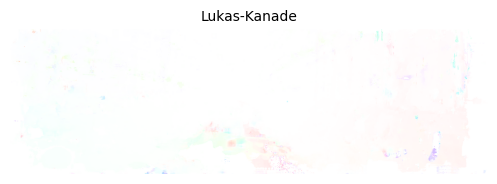

In [12]:
import matplotlib.pyplot as plt
import cv2

def flow_to_img(flow, normalize=True, info=None, flow_mag_max=None):
    """Convert flow to viewable image, using color hue to encode flow vector orientation, and color saturation to
    encode vector length. This is similar to the OpenCV tutorial on dense optical flow, except that they map vector
    length to the value plane of the HSV color model, instead of the saturation plane, as we do here.
    Args:
        flow: optical flow
        normalize: Normalize flow to 0..255
        info: Text to superimpose on image (typically, the epe for the predicted flow)
        flow_mag_max: Max flow to map to 255
    Returns:
        img: viewable representation of the dense optical flow in RGB format
        flow_avg: optionally, also return average flow magnitude
    Ref:
        - OpenCV 3.0.0-dev documentation » OpenCV-Python Tutorials » Video Analysis »
        https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html
    """
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    flow_magnitude, flow_angle = cv2.cartToPolar(flow[..., 0].astype(np.float32), flow[..., 1].astype(np.float32))

    # A couple times, we've gotten NaNs out of the above...
    nans = np.isnan(flow_magnitude)
    if np.any(nans):
        nans = np.where(nans)
        flow_magnitude[nans] = 0.

    # Normalize
    hsv[..., 0] = flow_angle * 180 / np.pi / 2
    if normalize is True:
        if flow_mag_max is None:
            hsv[..., 1] = cv2.normalize(flow_magnitude, None, 0, 255, cv2.NORM_MINMAX)
        else:
            hsv[..., 1] = flow_magnitude * 255 / flow_mag_max
    else:
        hsv[..., 1] = flow_magnitude
    hsv[..., 2] = 255
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Add text to the image, if requested
    if info is not None:
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, info, (20, 20), font, 0.8, (0, 0, 0), 2, cv2.LINE_AA)

    return img

def plot_img_pairs_w_flows(
        img_pairs,
        flow_pyrs=None,
        num_lvls=0,
        flow_preds=None,
        flow_gts=None,
        titles=None,
        info=None,
        flow_mag_max=None):
    """Plot the given set of image pairs, optionally with flows and titles.
    Args:
        img_pairs: image pairs in [batch_size, 2, H, W, 3] or list([2, H, W, 3]) format.
        flow_pyrs: optional, predicted optical flow pyramids [batch_size, H, W, 2] or list([H, W, 2]) format.
        num_lvls: number of levels to show per pyramid (flow_pyrs must be set)
        flow_preds: optional, predicted flows in [batch_size, H, W, 2] or list([H, W, 2]) format.
        flow_gts: optional, groundtruth flows in [batch_size, H, W, 2] or list([H, W, 2]) format.
        titles: optional, list of image and flow IDs to display with each image.
        info: optional, stats to display above predicted flow
        flow_mag_max: Max flow to map to 255
    Returns:
        plt: plot
    """
    # Setup drawing canvas
    fig_height, fig_width = 5, 5
    row_count = len(img_pairs)
    col_count = 2
    #if flow_preds is not None:
    #    col_count += 1
    plt.figure(figsize=(fig_width * col_count, fig_height * row_count))

    # Plot img_pairs inside the canvas
    plot = 1
    for row in range(len(img_pairs)):
        # Plot image pair
        #plt.subplot(row_count, col_count, plot)
        #if titles is not None:
        #    plt.title(titles[row][0], fontsize=fig_width * 2)
        #plt.axis('off')
        #plt.imshow(img_pairs[row][0])
        #plt.subplot(row_count, col_count, plot + 1)
        if titles is not None:
            plt.title(titles[row][1], fontsize=fig_width * 2)
        plt.axis('off')
        plt.imshow(img_pairs[row][1])
        plot += 1

        # Plot predicted flow, if any
        if flow_preds is not None:
            plt.subplot(row_count, col_count, plot)
            title = "Lukas Kanade " + info[row] if info is not None else "Lukas-Kanade"
            plt.title(title, fontsize=fig_width * 2)
            plt.axis('off')
            plt.imshow(flow_to_img(flow_preds[row], flow_mag_max=flow_mag_max))
            plot += 1

    plt.tight_layout()
    return plt

def display_img_pairs_w_flows(
        img_pairs,
        flow_preds=None,
        flow_gts=None,
        titles=None,
        info=None,
        flow_mag_max=None):
    """Display the given set of image pairs, optionally with flows and titles.
    Args:
        img_pairs: image pairs in [batch_size, 2, H, W, 3] or list([2, H, W, 3]) format.
        flow_preds: optional, predicted flows in [batch_size, H, W, 2] or list([H, W, 2]) format.
        flow_gts: optional, groundtruth flows in [batch_size, H, W, 2] or list([H, W, 2]) format.
        titles: optional, list of image and flow IDs to display with each image.
        info: optional, stats to display above predicted flow
        flow_mag_max: Max flow to map to 255
    """
    plt = plot_img_pairs_w_flows(img_pairs, None, 0, flow_preds, flow_gts, titles, info, flow_mag_max)
    plt.show()
img_prev = cv2.imread('../data_w1/img/000045_10.png', cv2.IMREAD_GRAYSCALE)
img = cv2.imread('../data_w1/img/000045_11.png', cv2.IMREAD_GRAYSCALE)
img_pairs = []
img_pairs.append((img_prev, img))
display_img_pairs_w_flows(img_pairs, [pred_flow])